In [4]:
import numpy as np
import xarray as xr
import os
import pandas as pd
import glob

In [5]:
import sys ; sys.path.append("../..")
from ppe_tools import *

In [6]:
# set directories
exp_dir = '/glade/work/linnia/CLM6-PPE/ctsm6_wave2/'

### 1. Define Parameters and Ranges

In [7]:
csv='ctsm6lhc_paramranges_11262024.csv'
df = pd.read_csv(csv)
df_main = df[df['include'] == 1]
df_flagged = df[df['include'] == 0]
params=df_main['param'].values
flags = df_main['flag']

In [8]:
# grouped parameters
KCN=['kc_nonmyc','kn_nonmyc','akc_active','akn_active','ekc_active','ekn_active']
ACCLIM_SF=['vcmaxse_sf','jmaxse_sf','tpuse_sf']
TAU = ['bgc_tau_s1','bgc_tau_s2','bgc_tau_s3']
RF_LS = ['bgc_rf_l1s1','bgc_rf_l2s1','bgc_rf_l3s2']
RF_SS = ['bgc_rf_s2s1', 'bgc_rf_s2s3', 'bgc_rf_s3s1']
RF_CWD = ['rf_cwdl2', 'bgc_rf_cwdl3']

flagged_dict = {'KCN':KCN,'ACCLIM_SF':ACCLIM_SF,'TAU':TAU,'RF_LS':RF_LS,'RF_SS':RF_SS,'RF_CWD':RF_CWD}

### 2. Build Parameter Dictionary

In [9]:
def get_minmax(df,p):
    ix       = df['param']==p
    minval   = df['min'][ix].values[0]
    maxval   = df['max'][ix].values[0]
    pftmin   = df['pft_mins'][ix].values[0]
    pftmax   = df['pft_maxs'][ix].values[0]
    thisloc  = df['loc'][ix].values[0]

    needs_pft = (minval=='pft')
    if needs_pft:
        thismin = np.zeros((79))
        thismin[0:17] = np.fromstring(pftmin, dtype='float', sep=',')
    elif 'percent' in minval:
        thismin = minval
    else:
        thismin = np.array(float(minval))

    needs_pft = (maxval=='pft')
    if needs_pft:
        thismax = np.zeros((79))
        thismax[0:17] = np.fromstring(pftmax, dtype='float', sep=',')
    elif 'percent' in maxval:
        thismax = maxval
    else:
        thismax = np.array(float(maxval))

    return thismin, thismax, thisloc

In [10]:
lhcs = {}
for param,flag in zip(params,flags):
    
    if not pd.notnull(flag):
        thismin,thismax,thisloc = get_minmax(df,param)
        lhcs[param]={'min':thismin,'max':thismax,'loc':thisloc,'flagged':[]}
    else:
        flagged={}
        for p in flagged_dict[param]:
            thismin,thismax,thisloc = get_minmax(df_flagged,p)
            flagged[p]={'min':thismin,'max':thismax,'loc':thisloc}
        lhcs[param]={'min':[],'max':[],'loc':thisloc,'flagged':flagged}

###  3. Load parameter sets

In [11]:
# Load parameter sets from dictionary
num_paramsets = 500 # set the number of ensemble members 
psets_dict = np.load('/glade/u/home/linnia/ctsm6_ppe/analysis_lhc/wave2_biome/params/wave2_paramsets_041325.npy',allow_pickle='TRUE').item()

def get_p_dict(p,i):
    return psets_dict[p][i]

exp=[[get_p_dict(p,i) for p in lhcs] for i in range(num_paramsets)]

### 4. Create the Ensemble Object

In [12]:
# 4a. instantiate the Ensemble object
basefile = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/paramfiles/lhc0000.nc'
pdir = exp_dir + 'paramfiles/'
ndir = exp_dir + 'namelist_mods/'
x    = Ensemble(basefile,pdir,ndir)

# 4b. add the new ensemble members
prefix = 'wave2'   #make your own prefix
nextnum=1
x.add_lhcs(lhcs,prefix,nextnum,num_paramsets,lhc=exp) 

### 5. Write the param_files

In [13]:
paramset_file = exp_dir + 'ctsm6wave2_04132025.txt'
x.write(lhcfile=paramset_file)

In [14]:
%%bash -s "$paramset_file"
# Check that the file was created
paramset_file=$1 

stat $paramset_file

  File: /glade/work/linnia/CLM6-PPE/ctsm6_wave2/ctsm6wave2_04132025.txt
  Size: 6491511   	Blocks: 12704      IO Block: 8388608 regular file
Device: 42h/66d	Inode: 1650111638  Links: 1
Access: (0644/-rw-r--r--)  Uid: (35240/  linnia)   Gid: ( 1000/    ncar)
Access: 2025-04-13 09:19:45.517299000 -0600
Modify: 2025-04-13 09:19:47.661014768 -0600
Change: 2025-04-13 09:19:47.661014768 -0600
 Birth: -


### 6. Sanity Check

In [12]:
import matplotlib.pyplot as plt

In [13]:
in_dir = exp_dir + 'paramfiles/'
filelist= np.sort(glob.glob(os.path.join(in_dir, '*')))

In [16]:
check = np.empty([20,3])
for j,f in enumerate(range(20)):
    par = xr.open_dataset(filelist[f])
    for i,p in enumerate(['bsw_sf','hksat_sf','watsat_sf']):
        val = par[p]
        check[j,i] = val

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy', 'rasterio']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

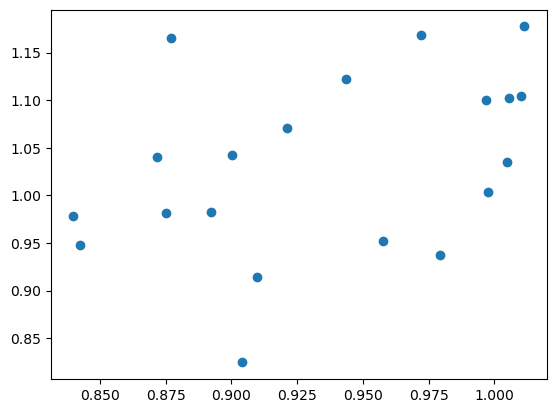

In [39]:
plt.scatter(check[:,0],check[:,2])